Script to load and visualize high frequency AOSLO data
Further, I look into low-pass filtering the data to smooth out experimental artifacts

In [1]:
import numpy as np
import os
from scipy.io import loadmat
from scipy.signal import butter, lfilter, freqz
from scipy.interpolate import interp1d
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
%matplotlib inline

# Load Data

In [2]:
data_dir = 'data_high_freq/'
fn_s = [fn for fn in os.listdir(data_dir) if fn.endswith('.mat')]
fn_s

['20094L_020_cw_nostim_bandfilt_1920_hz_8199.mat',
 '20094L_022_cw_nostim_bandfilt_1920_hz_304.mat',
 '20094L_023_cw_nostim_bandfilt_1920_hz_8905.mat',
 '20094L_028_cw_nostim_bandfilt_1920_hz_7292.mat',
 '20094L_031_cw_nostim_bandfilt_1920_hz_7874.mat',
 '20094L_033_cw_nostim_bandfilt_1920_hz_237.mat']

In [3]:
data = loadmat(os.path.join(data_dir, fn_s[1]))

In [4]:
scale = 1. / 392. * 60. # Conversion from pixels to arcmins

In [5]:
t = data['timeaxis_secs'][:, 0]
t = t - t[0]
xy = data['frameshifts_strips_spline'] * scale
x = data['frameshifts_strips_spline'][:, 0] * scale
y = data['frameshifts_strips_spline'][:, 1] * scale
x = x - x[0]
y = y - y[0]

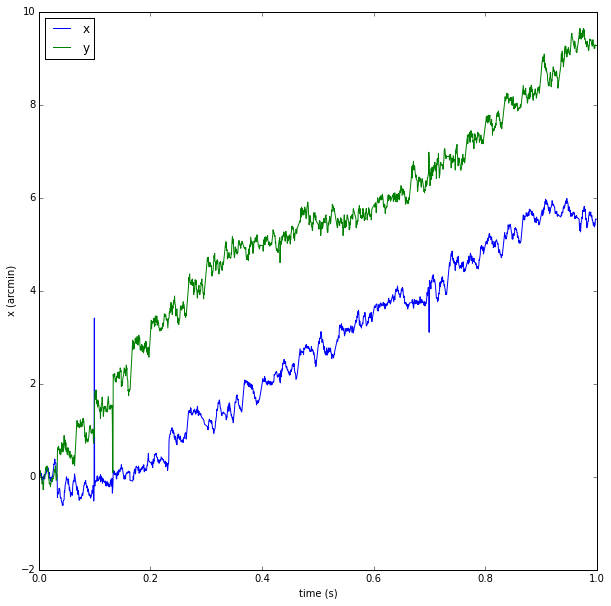

In [6]:
plt.figure(figsize = (10, 10))
plt.plot(t, x, label = 'x')
plt.plot(t, y, label = 'y')
plt.xlabel('time (s)')
plt.ylabel('x (arcmin)')
plt.legend(loc = 0)

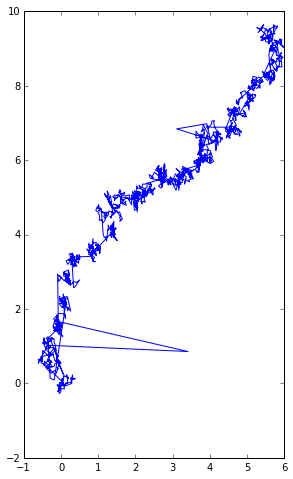

In [7]:
plt.figure(figsize=(8,8))
plt.plot(x, y)
plt.axes().set_aspect('equal')

Notice that there are jumps in the data, these should be smoothed out using a filter.

In [8]:
def moving_average(x, y, a = 7):
    """
    Moving average to smooth out 'jumps'
    a = 7 suggested by Roorda group
    """
    f = np.ones((a,))/ (1.0 * a)
    xf = np.convolve(f, x, mode = 'same')
    yf = np.convolve(f, y, mode = 'same')
    return xf, yf

In [9]:
xf, yf = moving_average(x, y)
xyf = np.zeros_like(xy)
xyf[:, 0] = xf
xyf[:, 1] = yf

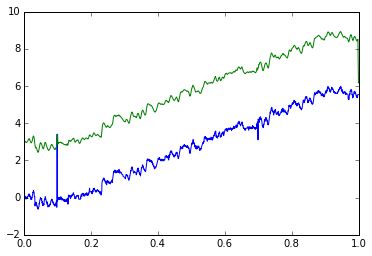

In [10]:
plt.plot(t, x, t, xf + 3)

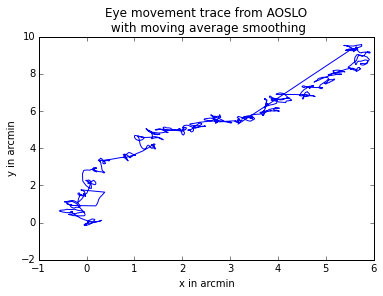

In [11]:
plt.plot(xf, yf)
plt.xlabel('x in arcmin')
plt.ylabel('y in arcmin')
plt.title('Eye movement trace from AOSLO\n with moving average smoothing')

Note that even though the data is at 3840 Hz, the system locks on to something and then jumps. Kavitha thinks that it is related to the tumbling E in the middle that she attempts to filter out (i.e. the jumps happen at the frequency of when the tumbling E changes). 

# Kalman Smoothing

In [12]:
e1 = np.array([[1, 0, 0, 0], 
               [0, 0, 0, 0], 
               [0, 0, 1, 0],
               [0, 0, 0, 0]])

e2 = np.array([[0, 0, 0, 0], 
               [0, 1, 0, 0], 
               [0, 0, 0, 0],
               [0, 0, 0, 1]])

In [13]:
dt = t[1] - t[0]

0.2 s - delta v = 30 arcmin/s
acceleration -> 150 arcmin/s^2
4000 samples / s
150 / 4000 = 0.04 arcmin/s/sample

In [14]:
150./4000

0.0375

In [15]:
sigma_p = 30. # Initial velocity standard deviation arcmin/s
sigma_t = 0.04 # Hidden state transition noise
sigma_o = 0.01 # Observation noise

In [16]:
kf = KalmanFilter(transition_matrices = [[1, dt, 0, 0], 
                                         [0, 1, 0, 0], 
                                         [0, 0, 1, dt],
                                         [0, 0, 0, 1]],
                  transition_covariance = sigma_t * e2,
                  observation_matrices = [[1, 0, 0, 0], 
                                          [0, 0, 1, 0]],
                  observation_covariance = sigma_o * np.eye(2),
                  initial_state_mean = np.zeros(4),
                  initial_state_covariance = sigma_p * e2
                  )
                    
measurements = xyf
#kf = kf.smooth(measurements)
#kf = kf.em(measurements, n_iter=5)
#(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)


In [17]:
np.round(smoothed_state_covariances[-1], decimals = 2)

array([[ 0.  ,  0.02,  0.  ,  0.  ],
       [ 0.02,  1.75,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.02],
       [ 0.  ,  0.  ,  0.02,  1.75]])

In [18]:
Xh = smoothed_state_means[:, (0,2)]
Vh = smoothed_state_means[:, (1,3)]

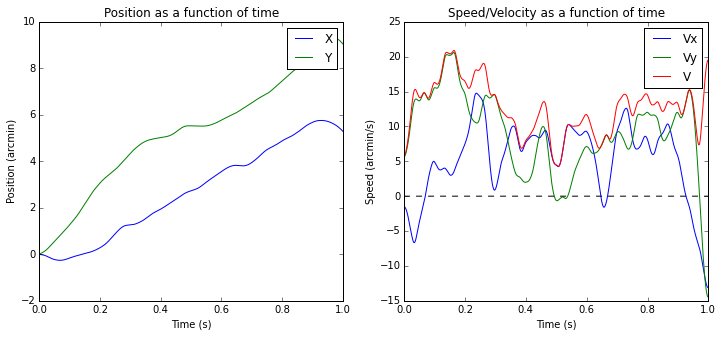

In [19]:
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.plot(t, Xh[:, 0], label = 'X')
plt.plot(t, Xh[:, 1], label = 'Y')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Position (arcmin)')
plt.title('Position as a function of time')

plt.subplot(1, 2, 2)
plt.plot(t, Vh[:, 0], label = 'Vx')
plt.plot(t, Vh[:, 1], label = 'Vy')
plt.plot(t, np.sqrt(Vh[:, 0] ** 2 + Vh[: , 1] ** 2), label = 'V')
plt.plot(t, np.zeros_like(t), 'k--')

plt.title('Speed/Velocity as a function of time')
plt.xlabel('Time (s)')
plt.ylabel('Speed (arcmin/s)')
plt.legend()

In [20]:
colors = np.convolve(np.array([1,-1]), np.floor(t * 1.001 / 0.1 - 0.0001), mode = 'same')
idx = np.where(colors == 1)[0]

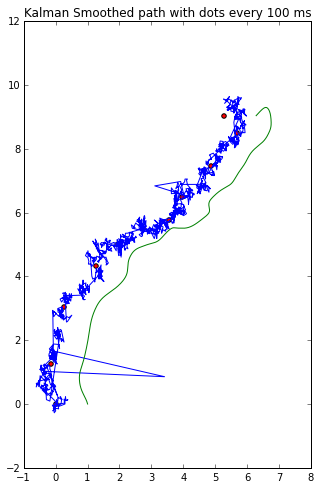

In [23]:
plt.figure(figsize = (8, 8))
plt.plot(x, y)

d = 1
plt.plot(Xh[:, 0] + d, Xh[:, 1])
plt.scatter(Xh[idx, 0], Xh[idx, 1], c = 'r')
plt.axes().set_aspect('equal')
plt.title('Kalman Smoothed path with dots every 100 ms')

# Model Validation: Histograms of Velocity

(array([  25.,   11.,   10.,   33.,  226.,  231.,  492.,  433.,  347.,  112.]),
 array([-14.45307726, -10.94747138,  -7.4418655 ,  -3.93625962,
         -0.43065375,   3.07495213,   6.58055801,  10.08616389,
         13.59176977,  17.09737564,  20.60298152]),
 <a list of 10 Patch objects>)

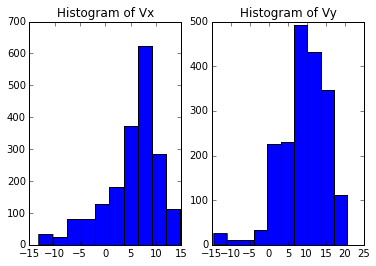

In [24]:
plt.subplot(1, 2, 1)
plt.title('Histogram of Vx')
plt.hist(Vh[:, 0])
plt.subplot(1, 2, 2)
plt.title('Histogram of Vy')
plt.hist(Vh[:, 1])

# Resampling

In order to do simulations, we will resample the smoothed data at 1000 Hz to go with the other simulations

In [25]:
resample_dt = 0.001 # seconds / sample
tp = np.arange(0, 1, resample_dt)

In [26]:
fx = interp1d(t, Xh[:, 0])
fy = interp1d(t, Xh[:, 1])
x_i = fx(tp)
y_i = fy(tp)

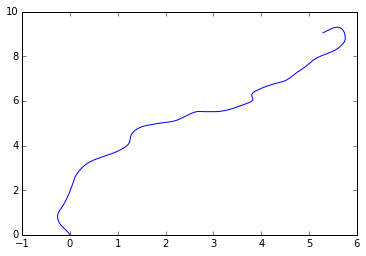

In [27]:
plt.plot(x_i, y_i)

# Power Spectrum

In [28]:
ps = np.fft.fftshift(np.abs(np.fft.fft(x)))
freqs = np.fft.fftshift(np.fft.fftfreq(x.size, 1/ 3840.))

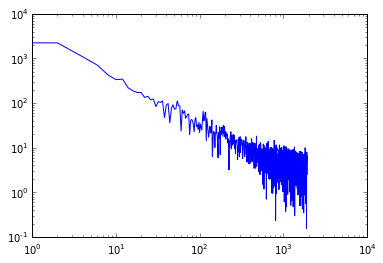

In [29]:
plt.plot(freqs, ps)
plt.yscale('log')
plt.xscale('log')

# Reference Image

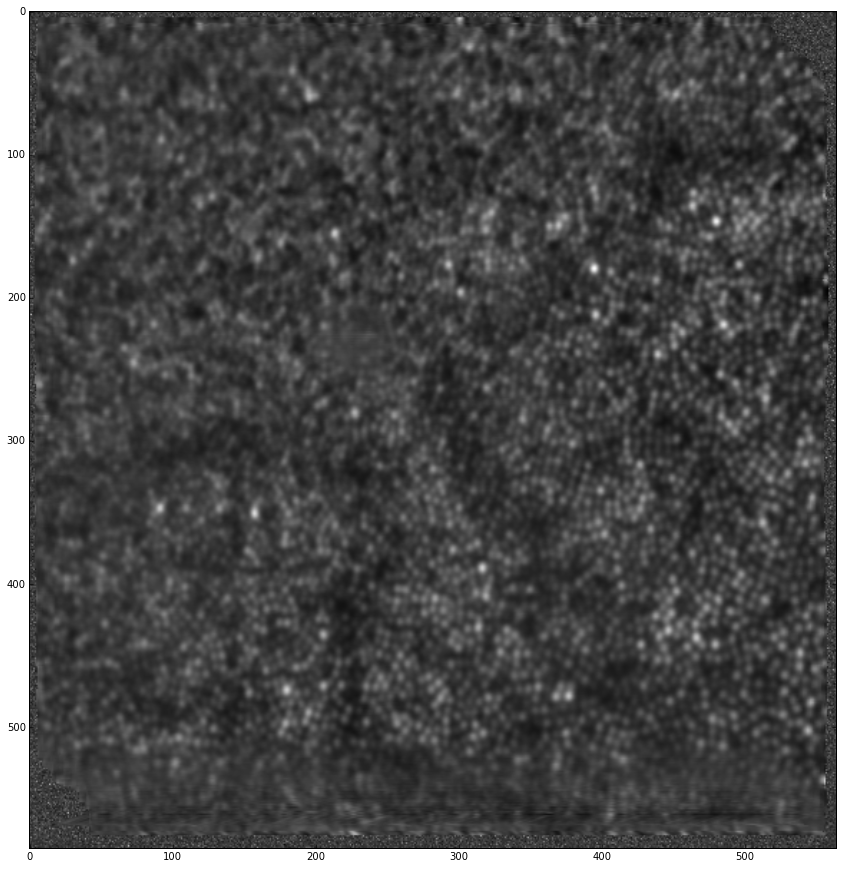

In [30]:
plt.figure(figsize=(15, 15))
plt.imshow(data['referenceimage'], cmap = plt.cm.gray)

# Lowpass filtering

As the movement should be quantized as it looks like before, we do a more aggressive filtering

In [31]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [32]:
cutoff = 20. #Hz
xb = butter_lowpass_filter(x, cutoff, 3840.)
yb = butter_lowpass_filter(y, cutoff, 3840.)

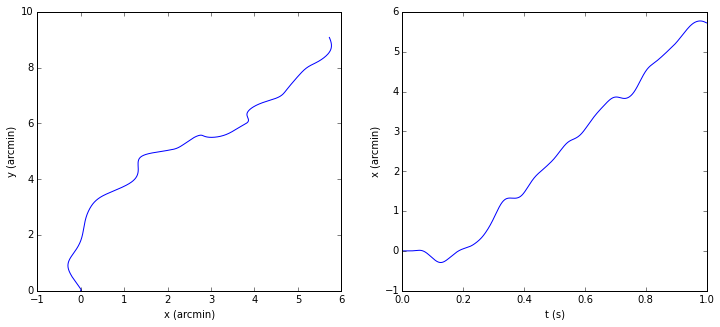

In [33]:
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.plot(xb, yb, '-')
plt.xlabel('x (arcmin)')
plt.ylabel('y (arcmin)')
plt.subplot(1, 2, 2)
plt.plot(t, xb)
plt.xlabel('t (s)')
plt.ylabel('x (arcmin)')

Notice that this doesn't look very good to just low pass the eye movements.